SD-TSIA210 (Cr D) - Machine Learning Project

Group2: Mohamad Abdallah & Karim Rustom 


#Regression - Communities and Crime Data Set:
https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime

The Crime Dataset contains 128 socio-economic features from the US 1990 Census. The target is the crime rate per community.

In [ ]:
from pandas import read_csv
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
from time import time
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data
!{ printf 'attributes\n'; cat communities.names | grep @attribute | cut -d ' ' -f 2; } > communities.attributes
attrib = read_csv('communities.attributes')
data = read_csv('communities.data', names = attrib['attributes'])

--2021-06-26 23:24:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27179 (27K) [application/x-httpd-php]
Saving to: ‘communities.names.4’

communities.names.4 100%[===================>]  26.54K  --.-KB/s    in 0.05s   

2021-06-26 23:24:04 (516 KB/s) - ‘communities.names.4’ saved [27179/27179]

--2021-06-26 23:24:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1102815 (1.1M) [application/x-httpd-php]
Saving to: ‘communities.data.4’

communities.data.4  100%[=================

In [ ]:
print(data.shape)
data.head()

(1994, 128)


,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,...,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,...,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,...,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,...,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,...,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,...,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


Remove non-predictive features:

- state: US state (by number) - not counted as predictive
- county: numeric code for county - not predictive, and many missing values
- community: numeric code for community - not predictive and many missing values
- communityname: community name - not predictive - for information only
- fold: fold number for non-random 10 fold cross validation, potentially useful for debugging, paired tests - not predictive

In [ ]:
data = data.drop(columns=['state','county','community','communityname','fold'], axis=1)
print(data.shape)
data.head()

(1994, 123)


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,...,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,...,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,...,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,...,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,0.38,0.42,0.46,0.22,0.27,...,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


#looking for missing values

In [ ]:
data = data.replace('?', np.nan)
feat_miss = data.columns[data.isnull().any()]
print(feat_miss)
feat_miss.shape

Index(['OtherPerCap', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps',
       'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop',
       'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol',
       'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian',
       'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz',
       'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr',
       'LemasGangUnitDeploy', 'PolicBudgPerPop'],
      dtype='object')


(23,)

From 122 predictive features, we have 23 contain missing values.

Lets look at them

In [ ]:
data[feat_miss].describe()

,OtherPerCap,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,PolicBudgPerPop
count,1993,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319
unique,97,38,52,34,55,44,59,75,52,76,74,73,54,50,72,30,15,77,63,38,72,3,51
top,0,0.02,0.1,0.98,0.19,0.02,0.14,0.23,0.1,0.78,0.72,0,0,0,0.07,0.03,0.57,0.19,0.02,0.02,0.84,0,0.12
freq,129,80,19,81,17,55,23,15,19,12,11,23,72,189,14,48,54,12,27,69,13,126,22


- As we can see, "*OtherPerCap*" has only one missing value, so we will fill it by the mean value. 
- The others features present many missing values, so we will remove them from the data set.

In [ ]:
#we will fill it by the mean value
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(data[['OtherPerCap']])
data[['OtherPerCap']] = imputer.transform(data[['OtherPerCap']])

In [ ]:
#we will remove the others from the data set
data = data.dropna(axis=1)

In [ ]:
print(data.shape)
data.head()

(1994, 101)


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,...,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,...,0.10,0.16,0.10,0.17,0.29,0.17,0.26,0.20,0.82,0.0,0.02,0.79,0.24,0.02,0.25,0.65,0.16,0.00,0.21,0.20,0.21,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,...,0.04,0.20,0.20,0.46,0.52,0.43,0.42,0.15,0.51,0.5,0.01,0.86,0.41,0.29,0.30,0.52,0.47,0.45,0.18,0.17,0.16,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,...,0.08,0.56,0.62,0.85,0.77,1.00,0.94,0.12,0.01,0.5,0.01,0.97,0.96,0.60,0.47,0.52,0.11,0.11,0.24,0.21,0.19,0.75,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,0.38,0.42,0.46,0.22,0.27,...,0.05,0.16,0.19,0.59,0.60,0.37,0.89,0.02,0.19,0.5,0.01,0.89,0.87,0.04,0.55,0.73,0.05,0.14,0.31,0.31,0.30,0.40,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


In [ ]:
data.describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,...,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000
mean,0.057593,0.463395,0.179629,0.753716,0.153681,0.144022,0.424218,0.493867,0.336264,0.423164,0.064072,0.696269,0.361123,0.558154,0.291570,0.495687,0.471133,0.317778,0.479248,0.375677,0.350251,0.368049,0.291098,0.203506,0.322357,0.284742,0.386279,0.055507,0.303024,0.315807,0.383330,0.361675,0.363531,0.501073,0.396384,0.440597,0.391224,0.441339,0.461244,0.434453,...,0.150587,0.267608,0.251891,0.462101,0.494428,0.404097,0.562598,0.186264,0.495186,0.314694,0.076815,0.719549,0.548686,0.204529,0.433335,0.494178,0.264478,0.243059,0.264689,0.263490,0.268942,0.346379,0.372457,0.422964,0.384102,0.490125,0.449754,0.403816,0.029438,0.022778,0.215552,0.608892,0.535050,0.626424,0.651530,0.065231,0.232854,0.161685,0.094052,0.237979
std,0.126906,0.163717,0.253442,0.244039,0.208877,0.232492,0.155196,0.143564,0.166505,0.179185,0.128256,0.444811,0.209362,0.182913,0.204108,0.178071,0.173619,0.222137,0.167564,0.198257,0.191109,0.186804,0.171593,0.164775,0.195411,0.190960,0.183081,0.127941,0.228474,0.213360,0.202508,0.209193,0.202171,0.174036,0.202386,0.175457,0.198922,0.186292,0.182460,0.175437,...,0.219716,0.196567,0.190709,0.169551,0.157924,0.189301,0.197087,0.209956,0.172508,0.255182,0.150465,0.194024,0.185204,0.217770,0.188986,0.232467,0.242847,0.206295,0.224425,0.231542,0.235252,0.219323,0.209278,0.248286,0.213404,0.169500,0.187274,0.192593,0.102607,0.100400,0.231134,0.204329,0.181352,0.200521,0.198221,0.109459,0.203092,0.229055,0.240328,0.232985
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

As we can see now, there is no missing features


*ViolentCrimesPerPop*: total number of violent crimes per 100K popuation - the attribute to be predicted.

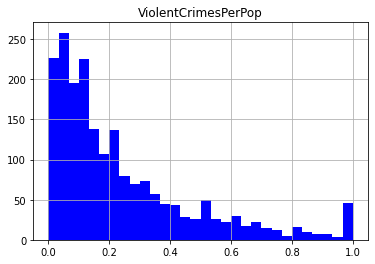

In [ ]:
data.hist(column = ['ViolentCrimesPerPop'], bins = 30, color = 'blue')
plt.show()

#Correlations

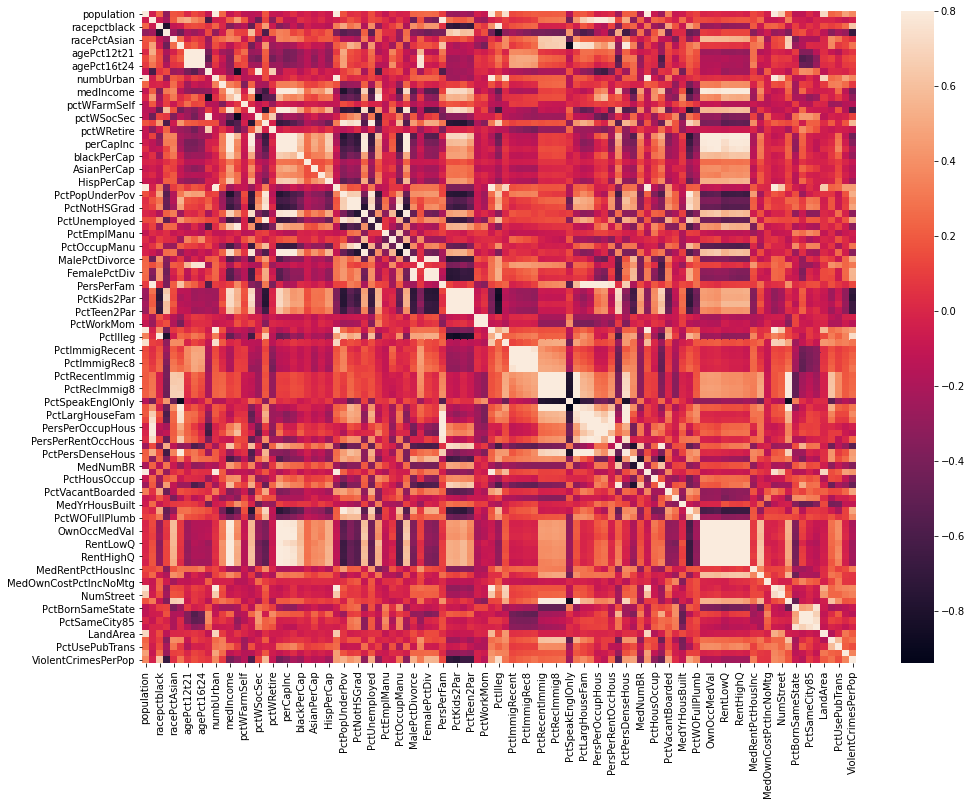

In [ ]:
corrmat = data.corr()
fig = plt.figure(figsize = (16, 12))
sns.heatmap(corrmat, vmax = 0.8)
plt.show()

In [ ]:
corrT = data.corr(method = 'pearson').round(4)
corrT = corrT.sort_values(by=['ViolentCrimesPerPop'])
corrT['ViolentCrimesPerPop']

PctKids2Par           -0.7384
PctFam2Par            -0.7067
racePctWhite          -0.6848
PctYoungKids2Par      -0.6661
PctTeen2Par           -0.6616
                        ...  
FemalePctDiv           0.5560
pctWPubAsst            0.5747
racepctblack           0.6313
PctIlleg               0.7380
ViolentCrimesPerPop    1.0000
Name: ViolentCrimesPerPop, Length: 101, dtype: float64

- PctKids2Par: percentage of kids in family housing with two parents
- PctIlleg: percentage of kids born to never married (numeric - decimal) 

as we can see, It is logical and reasonable that PctKids2Par is very negatively correlated to ViolentCrimesPerPop because in these case the more the percentage is high, the less we have ViolentCrimesPerPop. In the oppsite, PctIlleg very positively correlated to ViolentCrimesPerPop because in these case the more the percentage is high, the more we have ViolentCrimesPerPop (possibility of doing crimes in these societies is high)

#Dimensionality Reduction

Using PCA: Principal Component Analysis

The dataset contain many variables highly correlated. Multicolinearity will increase the model variance. Dimensionality reduction utilizing PCA can provide an optimal set of orthogonal features. 

splitting data into train and test data

In [ ]:
X = data.iloc[:, 0:100].values
y = data.iloc[:, 100].values

seed = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = seed)

print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1994, 100)
(1994,)
(1395, 100)
(1395,)
(599, 100)
(599,)


Mean and std for each data feature

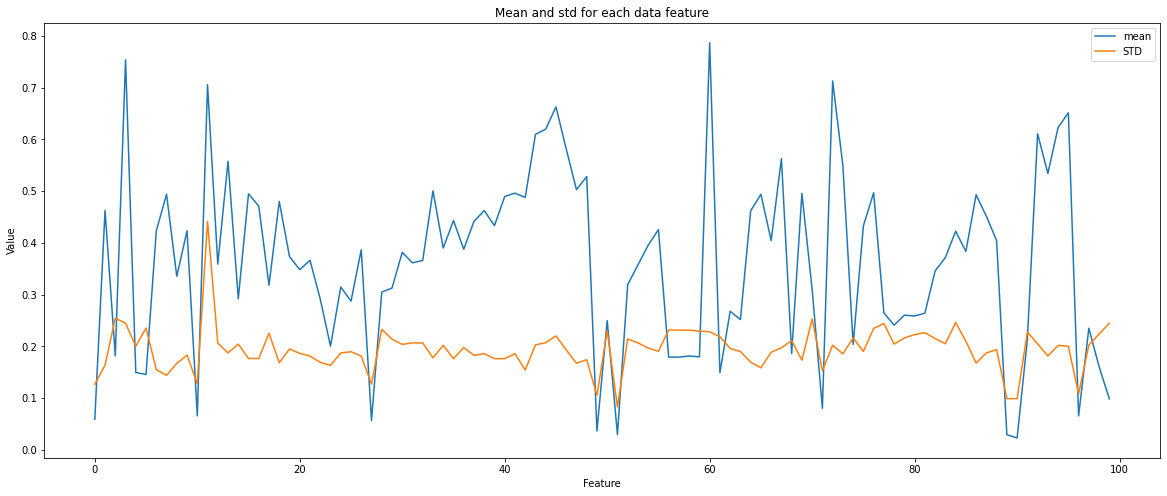

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(X_train.mean(axis=0), label='mean')
plt.plot(X_train.std(axis=0), label='STD')
plt.title('Mean and std for each data feature')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.legend()
plt.show()

As we can see, the data isn't scaled

Before applying PCA, we need to standardize our features by removing the mean, then scaling to unit variance

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

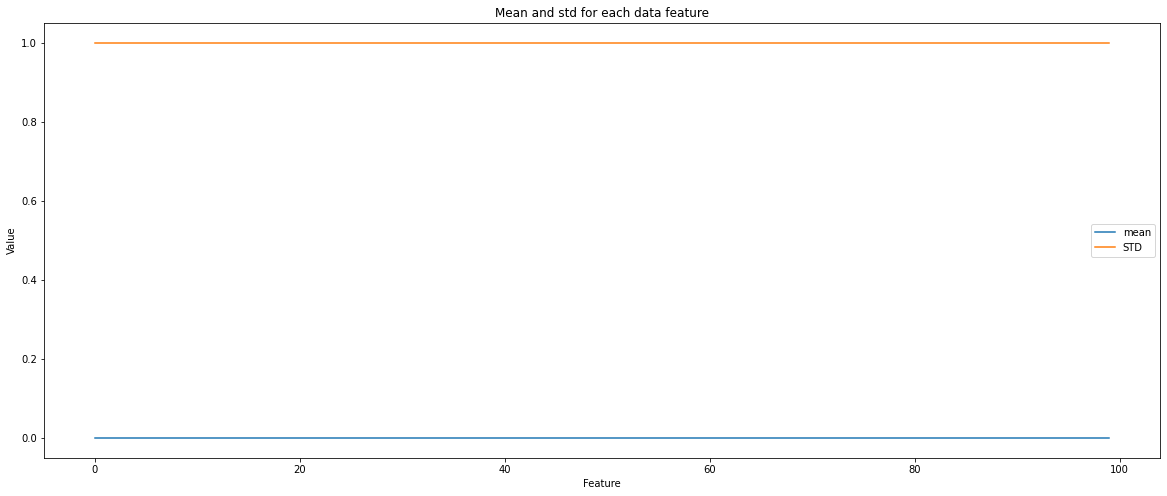

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(X_train.mean(axis=0), label='mean')
plt.plot(X_train.std(axis=0), label='STD')
plt.title('Mean and std for each data feature')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.legend()
plt.show()

With  90.0 %  of explained variability, we use  22  principal components.


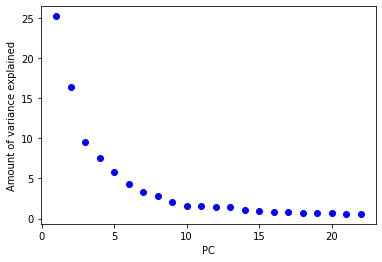

(1395, 22)


In [ ]:
# Threshold defined as 99% of the variability
Threshold_PCA = 0.9

# Fitting PCA
pca = PCA(Threshold_PCA).fit(X_train)

# Transforming training data
X_train_PCA = pca.transform(X_train)

# Transforming testing data
X_test_PCA=pca.transform(X_test)

print('With ', 100*Threshold_PCA,'%  of explained variability, we use ',pca.n_components_,' principal components.')  

c = pca.n_components_
plt.scatter(np.arange(1,(c+1)),pca.explained_variance_, c = 'blue')
plt.xlabel('PC')
plt.ylabel('Amount of variance explained')
plt.show()
print(X_train_PCA.shape)

to save all the results

In [ ]:
result = pd.DataFrame()

# Linear Regression: LR

##without PCA

In [ ]:
LR = LinearRegression()
trainingTime=time()
LR.fit(X_train, y_train)
trainingTime=time() - trainingTime
print("training time = ",trainingTime)
print("Using LinearRegression")
for i in range(len(data.columns) - 1):
    print(f'for {data.columns[i]}, coefficient = {LR.coef_[i]}')

training time =  0.042766571044921875
Using LinearRegression
for population, coefficient = 0.04227265956444249
for householdsize, coefficient = 0.008366391069239663
for racepctblack, coefficient = 0.05829209978635389
for racePctWhite, coefficient = -0.005753540611664779
for racePctAsian, coefficient = -0.006927447589590616
for racePctHisp, coefficient = 0.017656064120641225
for agePct12t21, coefficient = 0.01662462992460998
for agePct12t29, coefficient = -0.03687553645257763
for agePct16t24, coefficient = -0.021247547741295527
for agePct65up, coefficient = 0.014874489924570748
for numbUrban, coefficient = -0.05371125356561574
for pctUrban, coefficient = 0.023996331658627638
for medIncome, coefficient = -0.05111130706133768
for pctWWage, coefficient = -0.025590317156059732
for pctWFarmSelf, coefficient = 0.008491627746853109
for pctWInvInc, coefficient = -0.03315320237959814
for pctWSocSec, coefficient = 0.01983871085306182
for pctWPubAsst, coefficient = 0.019641910979184232
for pctWRet

In [ ]:
i = np.argmax(np.abs(LR.coef_))
print("feature:",data.columns[i],"of index:",i,"has the max coef:",LR.coef_[i])

feature: PctRecImmig8 of index: 58 has the max coef: 0.15657798661262887


PctRecImmig8, percent of _population_ who have immigrated within the last 8 years, is the variable that affects the most our predicated variable y = ViolentCrimesPerPop

In [ ]:
i = np.argmin(np.abs(LR.coef_))
print("feature:",data.columns[i],"of index:",i,"has the min coef:",LR.coef_[i])


feature: PctSameState85 of index: 95 has the min coef: 0.00023666123742245929


PctSameState85 , percent of people living in the same state as in 1985 (5 years before), is the variable that affects the leat our predicated variable y = ViolentCrimesPerPop

In [ ]:
testingTime=time()
y_pred = LR.predict(X_test)
testingTime=time() - testingTime
print("testing time = ",testingTime)

R2_train = LR.score(X_train, y_train)
R2_test = LR.score(X_test, y_test)
MSE_test = mean_squared_error(y_test, y_pred)

print(f'R^2 on the train set = {R2_train}')
print(f'R^2 on the test set = {R2_test}')

print(f'MSE on the test set = {MSE_test}')

testing time =  0.002845287322998047
R^2 on the train set = 0.7055992822298287
R^2 on the test set = 0.6443120559534243
MSE on the test set = 0.019084349346808367


In [ ]:
line = {'Regression': "LR No PCA", 'R2_train': R2_train, 'R2_test': R2_test, 'MSE_test': MSE_test,'training time':trainingTime,'testing time':testingTime}
new_row = pd.DataFrame(line, index=[1])
result = result.append(new_row)
result

,Regression,R2_train,R2_test,MSE_test,training time,testing time
1,LR No PCA,0.705599,0.644312,0.019084,0.042767,0.002845


##with PCA

In [ ]:
LR = LinearRegression()
trainingTime=time()
LR.fit(X_train_PCA, y_train)
trainingTime=time() - trainingTime
print("training time = ",trainingTime)

training time =  0.014023065567016602


Interpretation of the socio-economic factors that help explain violent crimes in communities is not possible since the original features were transformed in PCA.

In [ ]:
testingTime=time()
y_pred = LR.predict(X_test_PCA)
testingTime=time() - testingTime
print("testing time = ",testingTime)

R2_train = LR.score(X_train_PCA, y_train)
R2_test = LR.score(X_test_PCA, y_test)
MSE_test = mean_squared_error(y_test, y_pred)

print(f'R^2 on the train set = {R2_train}')
print(f'R^2 on the test set = {R2_test}')

print(f'MSE on the test set = {MSE_test}')

testing time =  0.0008089542388916016
R^2 on the train set = 0.6588524390562518
R^2 on the test set = 0.626349337319704
MSE on the test set = 0.020048134606787414


In [ ]:
line = {'Regression': "LR PCA", 'R2_train': R2_train, 'R2_test': R2_test, 'MSE_test': MSE_test,'training time':trainingTime,'testing time':testingTime}
new_row = pd.DataFrame(line, index=[2])
result = result.append(new_row)
result

,Regression,R2_train,R2_test,MSE_test,training time,testing time
1,LR No PCA,0.705599,0.644312,0.019084,0.042767,0.002845
2,LR PCA,0.658852,0.626349,0.020048,0.014023,0.000809


We can see that applying the PCA doesn't affect the result of the linear regression so much, but it gives a huge improvement in the speed of the training

We should mention that the PCA transformation cost time, but it is done only once

#SVR with Linear Kernel

##without PCA

In [ ]:
svr = SVR(kernel='linear')
trainingTime=time()
svr.fit(X_train, y_train)
trainingTime=time() - trainingTime
print("training time = ",trainingTime)


print("Using SVR with linear kernel")
print('The estimated parameters are:')

for i in range(len(data.columns) - 1):
  print(f'for {data.columns[i]}, coefficient = {svr.coef_[0][i]}')

training time =  5.777455568313599
Using SVR with linear kernel
The estimated parameters are:
for population, coefficient = -0.003988521458511807
for householdsize, coefficient = 0.0057289944307286345
for racepctblack, coefficient = 0.05291048611795879
for racePctWhite, coefficient = -0.0024587498668064978
for racePctAsian, coefficient = -0.01653867436336187
for racePctHisp, coefficient = 0.009889076683359477
for agePct12t21, coefficient = 0.010828982502656515
for agePct12t29, coefficient = -0.06817962995950316
for agePct16t24, coefficient = 0.017318846995406034
for agePct65up, coefficient = 0.010175659346359889
for numbUrban, coefficient = -0.01237559397851773
for pctUrban, coefficient = 0.013222687463808502
for medIncome, coefficient = -0.0422004830924112
for pctWWage, coefficient = -0.025232085432711715
for pctWFarmSelf, coefficient = 0.004493885729867753
for pctWInvInc, coefficient = -0.042819816317929416
for pctWSocSec, coefficient = 0.026423409035660317
for pctWPubAsst, coefficie

In [ ]:
i = np.argmax(np.abs(svr.coef_[0]))
print("feature:",data.columns[i],"of index:",i,"has the max coef:",svr.coef_[0][i])

feature: PctPersOwnOccup of index: 67 has the max coef: -0.15551166920005777


now, with SVR, PctPersOwnOccup, percent of people in owner occupied households, is the variable that affects the most our predicated variable

In [ ]:
i = np.argmin(np.abs(svr.coef_[0]))
print("feature:",data.columns[i],"of index:",i,"has the min coef:",svr.coef_[0][i])

feature: PctBornSameState of index: 92 has the min coef: -6.61213038316566e-05


PctBornSameState , percent of people born in the same state as currently living, is the variable that affects the least our predicated variable

In [ ]:
testingTime=time()
y_pred = svr.predict(X_test)
testingTime=time() - testingTime
print("testing time = ",testingTime)

R2_train = svr.score(X_train, y_train)
R2_test = svr.score(X_test, y_test)
MSE_test = mean_squared_error(y_test, y_pred)

print(f'R^2 on the train set = {R2_train}')
print(f'R^2 on the test set = {R2_test}')

print(f'MSE on the test set = {MSE_test}')

testing time =  0.058695316314697266
R^2 on the train set = 0.6945036590419271
R^2 on the test set = 0.643135662051198
MSE on the test set = 0.019147468472928097


In [ ]:
line = {'Regression': "SVR LK No PCA", 'R2_train': R2_train, 'R2_test': R2_test, 'MSE_test': MSE_test,'training time':trainingTime,'testing time':testingTime}
new_row = pd.DataFrame(line, index=[3])
result = result.append(new_row)
result

,Regression,R2_train,R2_test,MSE_test,training time,testing time
1,LR No PCA,0.705599,0.644312,0.019084,0.042767,0.002845
2,LR PCA,0.658852,0.626349,0.020048,0.014023,0.000809
3,SVR LK No PCA,0.694504,0.643136,0.019147,5.777456,0.058695


## with PCA

In [ ]:
svr = SVR(kernel='linear')
trainingTime=time()
svr.fit(X_train_PCA, y_train)
trainingTime=time() - trainingTime
print("training time = ",trainingTime)


print("Using SVR with linear kernel")

training time =  3.062748670578003
Using SVR with linear kernel


In [ ]:
testingTime=time()
y_pred = svr.predict(X_test_PCA)
testingTime=time() - testingTime
print("testing time = ",testingTime)

R2_train = svr.score(X_train_PCA, y_train)
R2_test = svr.score(X_test_PCA, y_test)
MSE_test = mean_squared_error(y_test, y_pred)

print(f'R^2 on the train set = {R2_train}')
print(f'R^2 on the test set = {R2_test}')

print(f'MSE on the test set = {MSE_test}')

testing time =  0.009118080139160156
R^2 on the train set = 0.6542978689705528
R^2 on the test set = 0.6254879560814508
MSE on the test set = 0.02009435180573037


In [ ]:
line = {'Regression': "SVR LK PCA", 'R2_train': R2_train, 'R2_test': R2_test, 'MSE_test': MSE_test,'training time':trainingTime,'testing time':testingTime}
new_row = pd.DataFrame(line, index=[4])
result = result.append(new_row)
result

,Regression,R2_train,R2_test,MSE_test,training time,testing time
1,LR No PCA,0.705599,0.644312,0.019084,0.042767,0.002845
2,LR PCA,0.658852,0.626349,0.020048,0.014023,0.000809
3,SVR LK No PCA,0.694504,0.643136,0.019147,5.777456,0.058695
4,SVR LK PCA,0.654298,0.625488,0.020094,3.062749,0.009118


also, close results, but huge improvement in time

#Linear SVR

##without PCA

In [ ]:
l_svr = LinearSVR(random_state=42)
trainingTime=time()
l_svr.fit(X_train, y_train) 
trainingTime=time() - trainingTime
print("Using  linear SVR kernel")
print("training time = ",trainingTime)

for i in range(len(data.columns) - 1):
    print(f'for {data.columns[i]}, coefficient = {l_svr.coef_[i]}')

Using  linear SVR kernel
training time =  0.4399240016937256
for population, coefficient = 0.05018927079294751
for householdsize, coefficient = -0.01757337800309473
for racepctblack, coefficient = 0.06754919221570299
for racePctWhite, coefficient = -0.0011434155740698809
for racePctAsian, coefficient = -0.006162180604338072
for racePctHisp, coefficient = 0.023391294499232506
for agePct12t21, coefficient = 0.017511377476646012
for agePct12t29, coefficient = -0.062097877160820325
for agePct16t24, coefficient = 0.021813657062835598
for agePct65up, coefficient = 0.014794327335878227
for numbUrban, coefficient = -0.08446186011856063
for pctUrban, coefficient = 0.0264205608219737
for medIncome, coefficient = -0.06413234406881431
for pctWWage, coefficient = -0.01801852138096375
for pctWFarmSelf, coefficient = 0.005622466544906362
for pctWInvInc, coefficient = -0.023532008357110522
for pctWSocSec, coefficient = -0.002992636161932244
for pctWPubAsst, coefficient = 0.030527727924439606
for pctWR

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
i = np.argmax(np.abs(l_svr.coef_))
print("feature:",data.columns[i],"of index:",i,"has the max coef:",l_svr.coef_[i])

feature: PctRecImmig8 of index: 58 has the max coef: 0.20755671267341683


In [ ]:
i = np.argmin(np.abs(l_svr.coef_))
print("feature:",data.columns[i],"of index:",i,"has the min coef:",l_svr.coef_[i])

feature: PctBornSameState of index: 92 has the min coef: -8.845677951450697e-05


same result of LR

In [ ]:
testingTime=time()
y_pred = l_svr.predict(X_test)
testingTime=time() - testingTime
print("testing time = ",testingTime)

R2_train = l_svr.score(X_train, y_train)
R2_test = l_svr.score(X_test, y_test)
MSE_test = mean_squared_error(y_test, y_pred)

print(f'R^2 on the train set = {R2_train}')
print(f'R^2 on the test set = {R2_test}')

print(f'MSE on the test set = {MSE_test}')

testing time =  0.00603938102722168
R^2 on the train set = 0.6650115690565758
R^2 on the test set = 0.6199864939177651
MSE on the test set = 0.020389531407983857


In [ ]:
line = {'Regression': "l_svr No PCA", 'R2_train': R2_train, 'R2_test': R2_test, 'MSE_test': MSE_test,'training time':trainingTime,'testing time':testingTime}
new_row = pd.DataFrame(line, index=[5])
result = result.append(new_row)
result

,Regression,R2_train,R2_test,MSE_test,training time,testing time
1,LR No PCA,0.705599,0.644312,0.019084,0.042767,0.002845
2,LR PCA,0.658852,0.626349,0.020048,0.014023,0.000809
3,SVR LK No PCA,0.694504,0.643136,0.019147,5.777456,0.058695
4,SVR LK PCA,0.654298,0.625488,0.020094,3.062749,0.009118
5,l_svr No PCA,0.665012,0.619986,0.020390,0.439924,0.006039


##with PCA

In [ ]:
l_svr = LinearSVR(random_state=42)
trainingTime=time()
l_svr.fit(X_train_PCA, y_train) 
trainingTime=time() - trainingTime
print("Using  linear SVR kernel with PCA")
print("training time = ",trainingTime)

Using  linear SVR kernel with PCA
training time =  0.16283869743347168


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
testingTime=time()
y_pred = l_svr.predict(X_test_PCA)
testingTime=time() - testingTime
print("testing time = ",testingTime)

R2_train = l_svr.score(X_train_PCA, y_train)
R2_test = l_svr.score(X_test_PCA, y_test)
MSE_test = mean_squared_error(y_test, y_pred)

print(f'R^2 on the train set = {R2_train}')
print(f'R^2 on the test set = {R2_test}')

print(f'MSE on the test set = {MSE_test}')

testing time =  0.008788585662841797
R^2 on the train set = 0.6167120041133163
R^2 on the test set = 0.599538486119908
MSE on the test set = 0.021486664248138436


In [ ]:
line = {'Regression': "l_svr PCA", 'R2_train': R2_train, 'R2_test': R2_test, 'MSE_test': MSE_test,'training time':trainingTime,'testing time':testingTime}
new_row = pd.DataFrame(line, index=[6])
result = result.append(new_row)
result

,Regression,R2_train,R2_test,MSE_test,training time,testing time
1,LR No PCA,0.705599,0.644312,0.019084,0.042767,0.002845
2,LR PCA,0.658852,0.626349,0.020048,0.014023,0.000809
3,SVR LK No PCA,0.694504,0.643136,0.019147,5.777456,0.058695
4,SVR LK PCA,0.654298,0.625488,0.020094,3.062749,0.009118
5,l_svr No PCA,0.665012,0.619986,0.020390,0.439924,0.006039
6,l_svr PCA,0.616712,0.599538,0.021487,0.162839,0.008789


#SVR with RBF Kernel

##without PCA

In [ ]:
rbf_svr = SVR()
trainingTime=time()
rbf_svr.fit(X_train, y_train)
trainingTime=time() - trainingTime
print("SVR with RBF Kernel")
print("training time = ",trainingTime)

testingTime=time()
y_pred = rbf_svr.predict(X_test)
testingTime=time() - testingTime
print("testing time = ",testingTime)

R2_train = rbf_svr.score(X_train, y_train)
R2_test = rbf_svr.score(X_test, y_test)
MSE_test = mean_squared_error(y_test, y_pred)

print(f'R^2 on the train set = {R2_train}')
print(f'R^2 on the test set = {R2_test}')
print(f'MSE on the test set = {MSE_test}')

SVR with RBF Kernel
training time =  0.23336219787597656
testing time =  0.05452537536621094
R^2 on the train set = 0.8565296673555922
R^2 on the test set = 0.5684152700355147
MSE on the test set = 0.023156572769055275


In [ ]:
line = {'Regression': "SVR_RBF No PCA", 'R2_train': R2_train, 'R2_test': R2_test, 'MSE_test': MSE_test,'training time':trainingTime,'testing time':testingTime}
new_row = pd.DataFrame(line, index=[7])
result = result.append(new_row)
result

,Regression,R2_train,R2_test,MSE_test,training time,testing time
1,LR No PCA,0.705599,0.644312,0.019084,0.042767,0.002845
2,LR PCA,0.658852,0.626349,0.020048,0.014023,0.000809
3,SVR LK No PCA,0.694504,0.643136,0.019147,5.777456,0.058695
4,SVR LK PCA,0.654298,0.625488,0.020094,3.062749,0.009118
5,l_svr No PCA,0.665012,0.619986,0.020390,0.439924,0.006039
6,l_svr PCA,0.616712,0.599538,0.021487,0.162839,0.008789
7,SVR_RBF No PCA,0.856530,0.568415,0.023157,0.233362,0.054525


##with PCA

In [ ]:
rbf_svr = SVR()
trainingTime=time()
rbf_svr.fit(X_train_PCA, y_train)
trainingTime=time() - trainingTime
print("SVR with RBF Kernel with PCA")
print("training time = ",trainingTime)

testingTime=time()
y_pred = rbf_svr.predict(X_test_PCA)
testingTime=time() - testingTime
print("testing time = ",testingTime)

R2_train = rbf_svr.score(X_train_PCA, y_train)
R2_test = rbf_svr.score(X_test_PCA, y_test)
MSE_test = mean_squared_error(y_test, y_pred)

print(f'R^2 on the train set = {R2_train}')
print(f'R^2 on the test set = {R2_test}')
print(f'MSE on the test set = {MSE_test}')

SVR with RBF Kernel with PCA
training time =  0.1350545883178711
testing time =  0.019773483276367188
R^2 on the train set = 0.8188195928682694
R^2 on the test set = 0.5900527091035426
MSE on the test set = 0.021995621286003457


In [ ]:
line = {'Regression': "SVR_RBF PCA", 'R2_train': R2_train, 'R2_test': R2_test, 'MSE_test': MSE_test,'training time':trainingTime,'testing time':testingTime}
new_row = pd.DataFrame(line, index=[8])
result = result.append(new_row)
result

,Regression,R2_train,R2_test,MSE_test,training time,testing time
1,LR No PCA,0.705599,0.644312,0.019084,0.042767,0.002845
2,LR PCA,0.658852,0.626349,0.020048,0.014023,0.000809
3,SVR LK No PCA,0.694504,0.643136,0.019147,5.777456,0.058695
4,SVR LK PCA,0.654298,0.625488,0.020094,3.062749,0.009118
5,l_svr No PCA,0.665012,0.619986,0.020390,0.439924,0.006039
6,l_svr PCA,0.616712,0.599538,0.021487,0.162839,0.008789
7,SVR_RBF No PCA,0.856530,0.568415,0.023157,0.233362,0.054525
8,SVR_RBF PCA,0.818820,0.590053,0.021996,0.135055,0.019773


#Decision Tree Regressor

##without PCA

In [ ]:
deci_tr = DecisionTreeRegressor(criterion='mse',random_state=42)
trainingTime=time()
deci_tr.fit(X_train, y_train)
trainingTime=time() - trainingTime
print("Decision Tree Regressor")
print("training time = ",trainingTime)

testingTime=time()
y_pred = deci_tr.predict(X_test)
testingTime=time() - testingTime
print("testing time = ",testingTime)

R2_train = deci_tr.score(X_train, y_train)
R2_test = deci_tr.score(X_test, y_test)
MSE_test = mean_squared_error(y_test, y_pred)

print(f'R^2 on the train set = {R2_train}')
print(f'R^2 on the test set = {R2_test}')
print(f'MSE on the test set = {MSE_test}')

Decision Tree Regressor
training time =  0.12375426292419434
testing time =  0.0018944740295410156
R^2 on the train set = 1.0
R^2 on the test set = 0.18876320427446158
MSE on the test set = 0.04352671118530885


In [ ]:
line = {'Regression': "deci_tr No PCA", 'R2_train': R2_train, 'R2_test': R2_test, 'MSE_test': MSE_test,'training time':trainingTime,'testing time':testingTime}
new_row = pd.DataFrame(line, index=[9])
result = result.append(new_row)
result

,Regression,R2_train,R2_test,MSE_test,training time,testing time
1,LR No PCA,0.705599,0.644312,0.019084,0.042767,0.002845
2,LR PCA,0.658852,0.626349,0.020048,0.014023,0.000809
3,SVR LK No PCA,0.694504,0.643136,0.019147,5.777456,0.058695
4,SVR LK PCA,0.654298,0.625488,0.020094,3.062749,0.009118
5,l_svr No PCA,0.665012,0.619986,0.020390,0.439924,0.006039
6,l_svr PCA,0.616712,0.599538,0.021487,0.162839,0.008789
7,SVR_RBF No PCA,0.856530,0.568415,0.023157,0.233362,0.054525
8,SVR_RBF PCA,0.818820,0.590053,0.021996,0.135055,0.019773
9,deci_tr No PCA,1.000000,0.188763,0.043527,0.123754,0.001894


##with PCA

In [ ]:
deci_tr = DecisionTreeRegressor(criterion='mse',random_state=42)
trainingTime=time()
deci_tr.fit(X_train_PCA, y_train)
trainingTime=time() - trainingTime
print("Decision Tree Regressor with PCA")
print("training time = ",trainingTime)

testingTime=time()
y_pred = deci_tr.predict(X_test_PCA)
testingTime=time() - testingTime
print("testing time = ",testingTime)

R2_train = deci_tr.score(X_train_PCA, y_train)
R2_test = deci_tr.score(X_test_PCA, y_test)
MSE_test = mean_squared_error(y_test, y_pred)

print(f'R^2 on the train set = {R2_train}')
print(f'R^2 on the test set = {R2_test}')
print(f'MSE on the test set = {MSE_test}')

Decision Tree Regressor with PCA
training time =  0.04250311851501465
testing time =  0.001295328140258789
R^2 on the train set = 1.0
R^2 on the test set = 0.12669258259288607
MSE on the test set = 0.046857095158597664


In [ ]:
line = {'Regression': "deci_tr PCA", 'R2_train': R2_train, 'R2_test': R2_test, 'MSE_test': MSE_test,'training time':trainingTime,'testing time':testingTime}
new_row = pd.DataFrame(line, index=[10])
result = result.append(new_row)
result

,Regression,R2_train,R2_test,MSE_test,training time,testing time
1,LR No PCA,0.705599,0.644312,0.019084,0.042767,0.002845
2,LR PCA,0.658852,0.626349,0.020048,0.014023,0.000809
3,SVR LK No PCA,0.694504,0.643136,0.019147,5.777456,0.058695
4,SVR LK PCA,0.654298,0.625488,0.020094,3.062749,0.009118
5,l_svr No PCA,0.665012,0.619986,0.020390,0.439924,0.006039
6,l_svr PCA,0.616712,0.599538,0.021487,0.162839,0.008789
7,SVR_RBF No PCA,0.856530,0.568415,0.023157,0.233362,0.054525
8,SVR_RBF PCA,0.818820,0.590053,0.021996,0.135055,0.019773
9,deci_tr No PCA,1.000000,0.188763,0.043527,0.123754,0.001894
10,deci_tr PCA,1.000000,0.126693,0.046857,0.042503,0.001295


For the deci_tr, we have a determination coefficient on the train set very higher than on the test set, so our model is overfitting on the train set.

the training determination coefficient is equal to 1.

#Random Forest

##without PCA

In [ ]:
randf = RandomForestRegressor(random_state=42)
trainingTime=time()
randf.fit(X_train, y_train)
trainingTime=time() - trainingTime
print("Random Forest")
print("training time = ",trainingTime)

testingTime=time()
y_pred = randf.predict(X_test)
testingTime=time() - testingTime
print("testing time = ",testingTime)

R2_train = randf.score(X_train, y_train)
R2_test = randf.score(X_test, y_test)
MSE_test = mean_squared_error(y_test, y_pred)

print(f'R^2 on the train set = {R2_train}')
print(f'R^2 on the test set = {R2_test}')
print(f'MSE on the test set = {MSE_test}')

Random Forest
training time =  6.489934206008911
testing time =  0.019649505615234375
R^2 on the train set = 0.9514987996130589
R^2 on the test set = 0.6317552410228304
MSE on the test set = 0.019758082170283804


In [ ]:
line = {'Regression': "Randf No PCA", 'R2_train': R2_train, 'R2_test': R2_test, 'MSE_test': MSE_test,'training time':trainingTime,'testing time':testingTime}
new_row = pd.DataFrame(line, index=[11])
result = result.append(new_row)
result

,Regression,R2_train,R2_test,MSE_test,training time,testing time
1,LR No PCA,0.705599,0.644312,0.019084,0.042767,0.002845
2,LR PCA,0.658852,0.626349,0.020048,0.014023,0.000809
3,SVR LK No PCA,0.694504,0.643136,0.019147,5.777456,0.058695
4,SVR LK PCA,0.654298,0.625488,0.020094,3.062749,0.009118
5,l_svr No PCA,0.665012,0.619986,0.020390,0.439924,0.006039
6,l_svr PCA,0.616712,0.599538,0.021487,0.162839,0.008789
7,SVR_RBF No PCA,0.856530,0.568415,0.023157,0.233362,0.054525
8,SVR_RBF PCA,0.818820,0.590053,0.021996,0.135055,0.019773
9,deci_tr No PCA,1.000000,0.188763,0.043527,0.123754,0.001894
10,deci_tr PCA,1.000000,0.126693,0.046857,0.042503,0.001295


##with PCA

In [ ]:
randf = RandomForestRegressor(random_state=42)
trainingTime=time()
randf.fit(X_train_PCA, y_train)
trainingTime=time() - trainingTime
print("Random Forest")
print("training time = ",trainingTime)

testingTime=time()
y_pred = randf.predict(X_test_PCA)
testingTime=time() - testingTime
print("testing time = ",testingTime)

R2_train = randf.score(X_train_PCA, y_train)
R2_test = randf.score(X_test_PCA, y_test)
MSE_test = mean_squared_error(y_test, y_pred)

print(f'R^2 on the train set = {R2_train}')
print(f'R^2 on the test set = {R2_test}')
print(f'MSE on the test set = {MSE_test}')

Random Forest
training time =  2.1000733375549316
testing time =  0.019069194793701172
R^2 on the train set = 0.9467841495192334
R^2 on the test set = 0.5661638267560836
MSE on the test set = 0.02327737340567612


In [ ]:
line = {'Regression': "Randf PCA", 'R2_train': R2_train, 'R2_test': R2_test, 'MSE_test': MSE_test,'training time':trainingTime,'testing time':testingTime}
new_row = pd.DataFrame(line, index=[12])
result = result.append(new_row)
result

,Regression,R2_train,R2_test,MSE_test,training time,testing time
1,LR No PCA,0.705599,0.644312,0.019084,0.042767,0.002845
2,LR PCA,0.658852,0.626349,0.020048,0.014023,0.000809
3,SVR LK No PCA,0.694504,0.643136,0.019147,5.777456,0.058695
4,SVR LK PCA,0.654298,0.625488,0.020094,3.062749,0.009118
5,l_svr No PCA,0.665012,0.619986,0.020390,0.439924,0.006039
6,l_svr PCA,0.616712,0.599538,0.021487,0.162839,0.008789
7,SVR_RBF No PCA,0.856530,0.568415,0.023157,0.233362,0.054525
8,SVR_RBF PCA,0.818820,0.590053,0.021996,0.135055,0.019773
9,deci_tr No PCA,1.000000,0.188763,0.043527,0.123754,0.001894
10,deci_tr PCA,1.000000,0.126693,0.046857,0.042503,0.001295


#Conclusion

The accuracy and performance levels of the linear regression proves to be the best one among all other regressions tested. 

It has:
- the lowest MSE (0.019084)
- thehighest determination coefficient R2 on test set (0.644312)
- without overfitting on the training dataset (0.705599).

For the deci_tr, we have an overfitting.

The other regression models have in general the same performace.

The highest determination coefficient on the test sets reached 0.65 which is not accurate enough.

We can also see the good impact of the dimensionality reduction with PCA, we could attend almost the same result, accuracy, and performance with only 22 features of 100, and with very court time for training and testing.